In [1]:
#Import all necessary libraries
import os
import sys
import json
import numpy as np
import imgaug.augmenters as iaa
import skimage.draw
import cv2
import tensorflow as tf
import keras
from PIL import Image, ImageDraw
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.visualize import display_instances
from mrcnn import visualize
import matplotlib.pyplot as plt
from os import listdir

C:\Users\Kaja\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
#Paths
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.abspath("C:Users/Kaja/Desktop/KatarinaZoricIT10_2019/mask_rcnn_coco.h5")

# Path to save logs and model checkpoints
LOGS_DIR = os.path.abspath("C:Users/Kaja/Desktop/KatarinaZoricIT10_2019/logs")

In [3]:
class Configuration(Config):
    # Give the configuration a recognizable name
    NAME = "Janika Balaz"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + Janika Balaz monument

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 150
    LEARNING_RATE = 0.001
        
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [4]:
class CustomDataset(utils.Dataset):

    def load_data(self, annotation_json, images_dir,isTrain,*n):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        if len(n) != 0:
            numberOfRealTrainPhotos=int(n[0])
        
        if(isTrain):
            source_name = "Train dataset"
        else:
            source_name="Validation dataset"
        for category in coco_json['categories']:
            class_id = category['id']+1
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            print(class_name)
            self.add_class(source_name, class_id, class_name)
        
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                if(isTrain and image_id<=numberOfRealTrainPhotos):
                    image_annotations = annotations[image_id]
                
                if(not isTrain):
                    image_annotations = annotations[image_id]
                
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations)

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
    
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [5]:
def PrepareDatasets():
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_data("C:/Users/Kaja/Desktop/KatarinaZoricIT10_2019/Slike/train/train_annotations.json", "C:/Users/Kaja/Desktop/KatarinaZoricIT10_2019/Slike/train/",True,93)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_data("C:/Users/Kaja/Desktop/KatarinaZoricIT10_2019/Slike/val/validation_annotations.json", "C:/Users/Kaja/Desktop/KatarinaZoricIT10_2019/Slike/val/",False)
    dataset_val.prepare()
    return dataset_train,dataset_val


In [1]:
DEVICE = "/gpu:0"
config = Configuration()
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="training", model_dir=LOGS_DIR,
                              config=config)

NameError: name 'Configuration' is not defined

In [ ]:
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

Janika Balaz Monument
Janika Balaz Monument


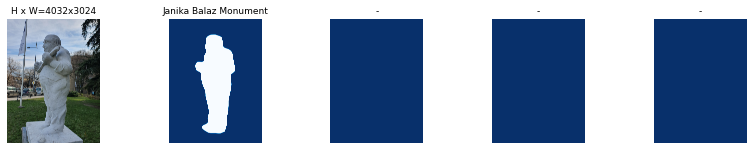

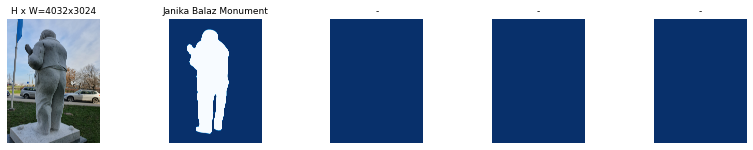

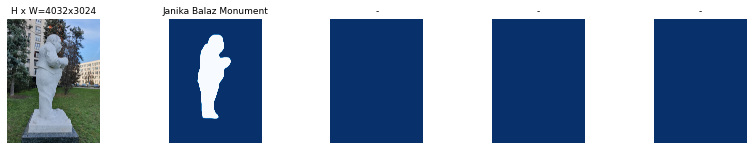

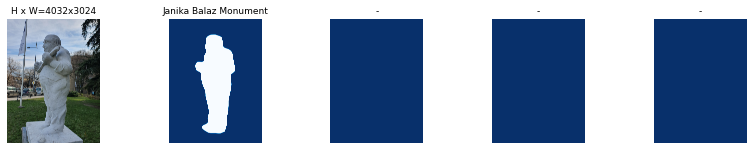

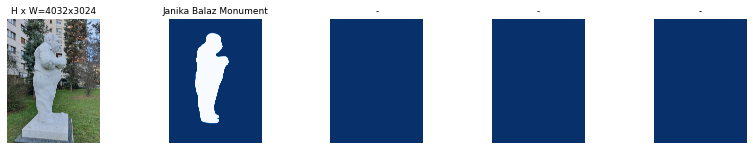

In [7]:
dataset_train,dataset_val =  PrepareDatasets()
image_ids = np.random.choice(dataset_val.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
DEVICE = "/gpu:0"
config = Configuration()
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="training", model_dir=LOGS_DIR,
                              config=config)

In [ ]:
weights_path = COCO_WEIGHTS_PATH
model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])


In [ ]:
model.train(dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=8,
    layers='heads',
    augmentation = iaa.Sequential([
    iaa.Fliplr(1),
    iaa.Multiply((0.8, 1.2),per_channel=0.2),
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5),per_channel=0.2),
    iaa.Affine(rotate=(-30, 30)),
], random_order=True))

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10,
            epochs=12, 
            layers="all",
            )